In [3]:
import os
import cv2

def preprocess_images_in_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_folder, filename)
            print(f"Processing: {image_path}")  

            image = cv2.imread(image_path)

            if image is None:
                print(f"Failed to load image: {image_path}")
                continue

            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                largest_contour = max(contours, key=cv2.contourArea)

                x, y, w, h = cv2.boundingRect(largest_contour)

                cropped_image = image[y:y+h, x:x+w]

                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, cropped_image)
                print(f"Saved cropped image to: {output_path}") 
            else:
                print(f"No contours found in image: {image_path}")  

def preprocess_all_categories(archive_folder):
    # Iterate over 'train' and 'test' folders
    for dataset_type in ['train', 'test']:
        dataset_path = os.path.join(archive_folder, dataset_type)
        if os.path.isdir(dataset_path):
            # Iterate over each category folder in 'train' and 'test'
            for category_folder in os.listdir(dataset_path):
                category_path = os.path.join(dataset_path, category_folder)

                if os.path.isdir(category_path):  # Ensure it's a directory
                    output_category_folder = os.path.join(dataset_path, f"cropped_{category_folder}")
                    preprocess_images_in_folder(category_path, output_category_folder)
                else:
                    print(f"Skipping non-directory item: {category_path}") 

# Define your archive folder path
archive_folder = 'archive'

preprocess_all_categories(archive_folder)

Processing: archive/train/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(20).jpg
Saved cropped image to: archive/train/cropped_ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(20).jpg
Processing: archive/train/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(214).jpg
Saved cropped image to: archive/train/cropped_ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(214).jpg
Processing: archive/train/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(77).jpg
Saved cropped image to: archive/train/cropped_ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(77).jpg
Processing: archive/train/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(185).jpg
Saved cropped image to: archive/train/cropped_ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(185).jpg
Processing: archive/train/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(98).jp

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# Define paths
train_path = 'archive/train'
test_path = 'archive/test'
target_width = 960
target_height = 540

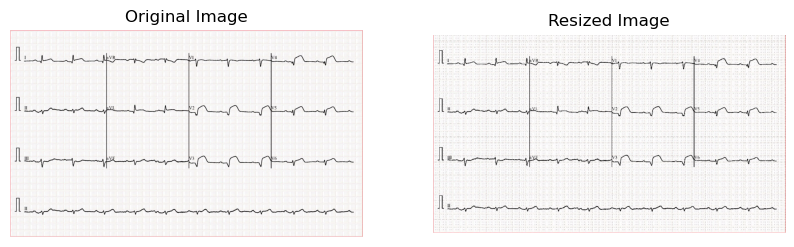

In [7]:
def preview_image(image_path, new_width, new_height):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Resized Image')
    plt.imshow(resized_image_rgb)
    plt.axis('off')

    plt.show()

image_path = 'archive/train/cropped_ECG Images of Myocardial Infarction Patients (240x12=2880)/MI(10).jpg'
preview_image(image_path, target_width, target_height)

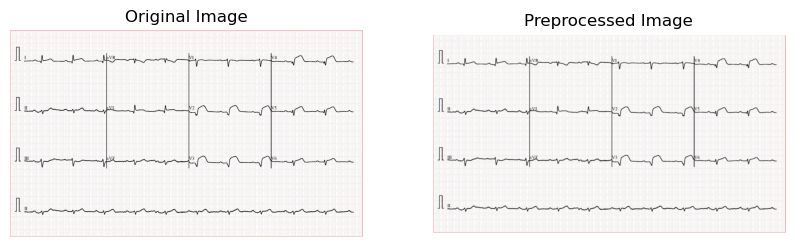

Found 864 images belonging to 5 classes.
Found 212 images belonging to 5 classes.
Found 448 images belonging to 4 classes.


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

train_path = 'archive/train'
test_path = 'archive/test'
target_width = 960
target_height = 540

def preprocess_image(image_path, new_width, new_height):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    resized_image = cv2.resize(blurred_image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    return resized_image

def preview_image(image_path, new_width, new_height):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    resized_image = preprocess_image(image_path, new_width, new_height)

    if resized_image is None:
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Preprocessed Image')
    plt.imshow(resized_image_rgb)
    plt.axis('off')
    plt.show()

image_path = 'archive/train/cropped_ECG Images of Myocardial Infarction Patients (240x12=2880)/MI(10).jpg'
preview_image(image_path, target_width, target_height)

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(target_height, target_width),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(target_height, target_width),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(target_height, target_width),
    batch_size=16,
    class_mode='categorical'
)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_height, target_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)



In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

In [23]:
model.save('ecg_classification_model.h5')

print("Model saved as ecg_classification_model.h5")

Model saved as ecg_classification_model.h5


In [10]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

def load_and_evaluate_model(model_path, test_generator):
    # Load the saved model
    model = load_model(model_path)
    
    # Evaluate the model on the test data
    loss, accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")
    
    # Predict the classes
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    
    # Generate a classification report
    print('Classification Report:')
    print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

    # Generate a confusion matrix
    print('Confusion Matrix:')
    print(confusion_matrix(test_generator.classes, y_pred))

# Example usage
model_path = 'ecg_classification_model.h5'  # Replace with your actual model path
load_and_evaluate_model(model_path, test_generator)

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 929ms/step - accuracy: 0.9955 - loss: 0.0180
Test Loss: 0.05108657851815224
Test Accuracy: 0.9888392686843872
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step
Classification Report:
                                                                          precision    recall  f1-score   support

      cropped_ECG Images of Myocardial Infarction Patients (240x12=2880)       0.29      0.29      0.29       112
     cropped_ECG Images of Patient that have History of MI (172x12=2064)       0.27      0.28      0.28       112
cropped_ECG Images of Patient that have abnormal heartbeat (233x12=2796)       0.22      0.21      0.22       112
                          cropped_Normal Person ECG Images (284x12=3408)       0.25      0.26      0.25       112

                                                                accuracy                           0.26       448
                                                               macro avg       0.26      0.26      0.26       4

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 538, 958, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 269, 479, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 267, 477, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 133, 238, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 131, 236, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 65, 118, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 981760)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   125,665,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,759,172 (479.73 MB)

 Trainable params: 125,759,172 (479.73 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

def preprocess_and_classify(image_path, model_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    # Preprocess the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_image = image[y:y+h, x:x+w]
    else:
        print("No contours found in image.")
        return

    # Resize the image to match the model's input size
    target_width, target_height = 960, 540  # As per your model
    resized_image = cv2.resize(cropped_image, (target_width, target_height), interpolation=cv2.INTER_CUBIC)

    # Convert image to array and normalize
    image_array = img_to_array(resized_image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    # Load the trained model
    model = load_model(model_path)

    # Predict the class
    predictions = model.predict(image_array)
    class_index = np.argmax(predictions[0])
    
    # Define class labels
    class_labels = ['Category1', 'Category2', 'Category3', 'Category4']  # Replace with your actual labels

    # Output the result
    predicted_class = class_labels[class_index]
    print(f"Predicted class: {predicted_class}")

# Example usage
image_path = 'unprocessed/test/Normal Person ECG Images (284x12=3408)/test (2).jpg'
model_path = 'ecg_classification_model.h5'
preprocess_and_classify(image_path, model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Predicted class: Category4
